## NYC Taxi Analysis

#### Goal of the Project:

###### 1. Analyze the peak times for taxi that will help drivers to maximize their income
###### 2. Understand different factors that influence taking taxis like weather conditions, seasons, etc.

###### We will import total 3 files for our analysis for the year 2022

1. NYC TLC Dataset
2. Taxi Zone Dataset
3. NYC Weather report 

In [81]:
from os.path import getsize
from urllib.request import urlretrieve

In [ ]:
# Output directory
output_dir = ".../NYC_taxi_analysis"

# download 2018 yellow taxi trip data
# fname = "yellow_tripdata_2018"

# change range(x, y) to be the months you want
# for m in list([1, 2, 7, 8]):
#    month = str(m).zfill(2)
#     out = f'{fname}-{month}.csv'
#     temp = f'{"yellow_2018"}_{month}.csv'
#     url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/{out}"
#     urlretrieve(url, f"{output_dir}/{temp}")

#     print(f"Done downloading {temp} to {output_dir} with size {getsize(f'{output_dir}/{temp}') / 1073741824:.2f}GB")

In [2]:
# I have downloaded the file directly from the website


## Data Preprocessing

In [3]:
# Importing libraries

import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calender
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
import warnings

In [111]:
!pip install geopandas
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory


In [4]:
!pip3 install pyarrow

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


#### Dataset 1: Loading Taxi zone data

In [5]:
# Importing Data

file_path_01 = '.../NYC_taxi_analysis/raw_data/yellow_tripdata_2022-01.parquet'
file_path_02 = '.../NYC_taxi_analysis/raw_data/yellow_tripdata_2022-02.parquet'
file_path_07 = '.../NYC_taxi_analysis/raw_data/yellow_tripdata_2022-07.parquet'
file_path_08 = '.../NYC_taxi_analysis/raw_data/yellow_tripdata_2022-08.parquet'


yellow_01 = pd.read_parquet(file_path_01)
yellow_02 = pd.read_parquet(file_path_02)
yellow_07 = pd.read_parquet(file_path_07)
yellow_08 = pd.read_parquet(file_path_08)


In [6]:
print(yellow_01.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-01-01 00:35:40   2022-01-01 00:53:29              2.0   
1         1  2022-01-01 00:33:43   2022-01-01 00:42:07              1.0   
2         2  2022-01-01 00:53:21   2022-01-01 01:02:19              1.0   
3         2  2022-01-01 00:25:21   2022-01-01 00:35:23              1.0   
4         2  2022-01-01 00:36:48   2022-01-01 01:14:20              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.80         1.0                  N           142           236   
1           2.10         1.0                  N           236            42   
2           0.97         1.0                  N           166           166   
3           1.09         1.0                  N           114            68   
4           4.30         1.0                  N            68           163   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [7]:
print(yellow_02.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-02-01 00:06:58   2022-02-01 00:19:24              1.0   
1         1  2022-02-01 00:38:22   2022-02-01 00:55:55              1.0   
2         1  2022-02-01 00:03:20   2022-02-01 00:26:59              1.0   
3         2  2022-02-01 00:08:00   2022-02-01 00:28:05              1.0   
4         2  2022-02-01 00:06:48   2022-02-01 00:33:07              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           5.40         1.0                  N           138           252   
1           6.40         1.0                  N           138            41   
2          12.50         1.0                  N           138           200   
3           9.88         1.0                  N           239           200   
4          12.16         1.0                  N           138           125   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [8]:
print(yellow_07.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-07-01 00:20:06   2022-07-01 00:39:13              1.0   
1         2  2022-07-01 00:29:11   2022-07-01 00:38:00              1.0   
2         1  2022-07-01 00:03:56   2022-07-01 00:11:49              1.0   
3         1  2022-07-01 00:18:36   2022-07-01 00:52:44              1.0   
4         1  2022-07-01 00:15:50   2022-07-01 00:22:21              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          10.10         1.0                  N            70            33   
1           1.67         1.0                  N           162            48   
2           0.90         1.0                  N            48           142   
3          14.80         1.0                  N            70           265   
4           1.20         1.0                  N           161           234   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [9]:
print(yellow_08.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-08-01 00:17:39   2022-08-01 00:19:58              1.0   
1         1  2022-08-01 00:26:06   2022-08-01 00:31:55              1.0   
2         1  2022-08-01 00:45:49   2022-08-01 00:59:29              1.0   
3         1  2022-08-01 00:05:49   2022-08-01 00:25:42              1.0   
4         1  2022-08-01 00:36:29   2022-08-01 00:51:29              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.4         1.0                  N           114           148   
1            1.4         1.0                  N            79           137   
2            5.2         1.0                  N            79            74   
3            9.4         1.0                  N           138           113   
4            1.7         1.0                  N           137            68   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [10]:
yellow_01.shape

(2463931, 19)

In [11]:
## Combining the monthly data as a Season (winter and summer)

winter = pd.concat([yellow_01, yellow_02]).reset_index(drop=True)
summer = pd.concat([yellow_07, yellow_08]).reset_index(drop=True)

## labeling dataset as winter and summer

winter['season'] = 'winter'
summer['season'] = 'summer'

# remove any invalid date

winter = winter[(winter['tpep_pickup_datetime'] >= '2022-01-01 00:00:00') 
    & (winter['tpep_pickup_datetime'] <= '2022-02-28 23:59:59') 
    & (winter['tpep_dropoff_datetime'] >= '2022-01-01 00:00:00') 
    & (winter['tpep_dropoff_datetime'] <= '2022-02-28 23:59:59')]
summer = summer[(summer['tpep_pickup_datetime'] >= '2022-07-01 00:00:00') 
    & (summer['tpep_pickup_datetime'] <= '2022-08-31 23:59:59') 
    & (summer['tpep_dropoff_datetime'] >= '2022-07-01 00:00:00') 
    & (summer['tpep_dropoff_datetime'] <= '2022-08-31 23:59:59')]

# Merging two dataset winter and summer

data = pd.concat([winter, summer]).reset_index(drop=True)

In [12]:
winter.shape

(5442763, 20)

In [13]:
summer.shape

(6326013, 20)

In [14]:
data.shape # 11M * 20 

(11768776, 20)

In [15]:
data.head(n=5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,season
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,winter
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,winter
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,winter
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,winter
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,winter


## Feature Engineering

In [17]:
## 1. Calculate duration of the trip and holidays

# We will calculate the duration of the trips. In order to calculate the duration we will first extract 
# day and time and then subtract drop off time from pickup time

In [18]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [19]:
# Normalize function will normalize times to midnight yielding only date in 'date' column

data['date'] = data['tpep_pickup_datetime'].dt.normalize()
data['time'] = data['tpep_pickup_datetime'].dt.hour            # extracts hour component from datetime
data['weekday'] = data['date'].dt.day_name()                   # extracts weekday from datetime
data['duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] # Duration = dropoff - pickup
data['duration'] = data['duration'] / np.timedelta64(1, 'm')   # converting duration to minutes

In [20]:
data.head(n=5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,season,date,time,weekday,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0.0,0.3,21.95,2.5,0.0,winter,2022-01-01,0,Saturday,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0.0,0.3,13.30,0.0,0.0,winter,2022-01-01,0,Saturday,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0.0,0.3,10.56,0.0,0.0,winter,2022-01-01,0,Saturday,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.0,0.3,11.80,2.5,0.0,winter,2022-01-01,0,Saturday,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0.0,0.3,30.30,2.5,0.0,winter,2022-01-01,0,Saturday,37.533333


In [21]:
# Since our one of the goals in the analysis is to look the peak times in workdays and holidays, we will
# create new columns that will help in distinguishing them

In [22]:
# Identifying holidays, weekend and workdays

cal = calender()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31') 
data['holiday'] = data['date'].isin(holidays)          # Creates a column holiday and mark holidays
data['week'] = data['date'].dt.dayofweek               # Numbers the week starting 0-Mon to 6-Sun
data.loc[data['week'] >= 5, 'day_type'] = "weekend"     
data.loc[data['week'] < 5, 'day_type'] = "workday"
data.loc[data['holiday'] == True, 'day_type'] = "holiday" # Creates a Column for day_type as weekday, holiday
data = data.drop(['holiday', 'week'], axis=1)             # drops the column holiday & week

In [23]:
data.head(n=5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,season,date,time,weekday,duration,day_type
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0.3,21.95,2.5,0.0,winter,2022-01-01,0,Saturday,17.816667,weekend
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0.3,13.30,0.0,0.0,winter,2022-01-01,0,Saturday,8.400000,weekend
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0.3,10.56,0.0,0.0,winter,2022-01-01,0,Saturday,8.966667,weekend
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.3,11.80,2.5,0.0,winter,2022-01-01,0,Saturday,10.033333,weekend
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0.3,30.30,2.5,0.0,winter,2022-01-01,0,Saturday,37.533333,weekend


In [24]:
# Calculating tip percentage using tip amount and total trip amount

data['tip_percent'] = (data.tip_amount / data.total_amount) * 100   # avg tip 12%


In [25]:
# Classifying trip's time slot in 4 categories: Morning, Afternoon, Evng & late night

def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'    # Note that in range syntax the start value is inclusive but stop value is exclusive

data['time_desc'] = data['time'].apply(time_slots)

In [26]:
# Dropping features that are not useful for analysis

data = data.drop(['store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge'], axis=1)

In [27]:
data.shape

(11768776, 23)

In [28]:
# Description statistics for continuous variables
data[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'duration', 'tip_percent']].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,duration,tip_percent
count,1.139721e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176691e+07
mean,1.409888e+00,5.701670e+00,1.397175e+01,2.566680e+00,4.737850e-01,2.050042e+01,1.599391e+01,1.197565e+01
std,9.842613e-01,5.737118e+02,1.177014e+02,3.068295e+00,1.905936e+00,1.181146e+02,4.751305e+01,8.000101e+00
min,0.000000e+00,0.000000e+00,-9.000000e+02,-1.880000e+02,-9.999000e+01,-8.953000e+02,-3.442400e+03,-5.555556e+02
25%,1.000000e+00,1.100000e+00,7.000000e+00,5.000000e-02,0.000000e+00,1.180000e+01,6.983333e+00,2.557545e-01
50%,1.000000e+00,1.860000e+00,9.500000e+00,2.060000e+00,0.000000e+00,1.535000e+01,1.140000e+01,1.660777e+01
75%,1.000000e+00,3.430000e+00,1.550000e+01,3.160000e+00,0.000000e+00,2.180000e+01,1.823333e+01,1.666667e+01
max,9.000000e+00,3.487985e+05,4.010923e+05,8.888800e+02,5.630900e+02,4.010956e+05,8.513183e+03,1.000000e+02


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

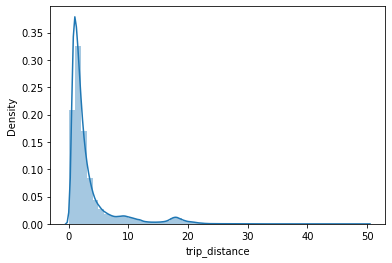

In [29]:
# Trip distance distribution
sns.distplot(data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 50)]['trip_distance'])

<AxesSubplot:xlabel='duration', ylabel='Density'>

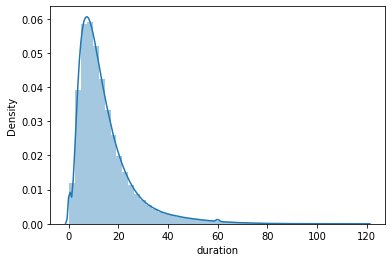

In [30]:
# Duration distribution
sns.distplot(data[(data['duration'] > 0) & (data['duration'] < 120)]['duration'])


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

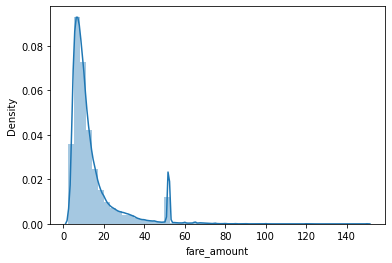

In [31]:
# Fare_amount distribution
sns.distplot(data[(data['fare_amount'] >= 2.5)&(data['fare_amount'] <= 150)]['fare_amount'])

<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

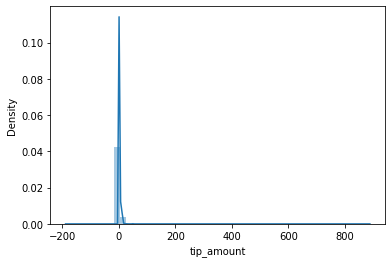

In [32]:
# Tip amount distribution
sns.distplot(data.tip_amount)

In [33]:
# remove invalid data
# passenger == 0
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 7)]

# trip_distance <= 0
data = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
data = data[(data['duration'] > 0) & (data['duration'] <= 180)]

# payment method other than cash and credit card
data = data[(data['payment_type'] != 3) & (data['payment_type'] != 4) & (data['payment_type'] != 5) & (data['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
data = data[(data['fare_amount'] >= 2.5) & (data['fare_amount'] <= 250)]

# remove trips with tip precentage over 50%
data = data[(data['tip_percent'] >= 0) & (data['tip_percent'] <= 50)]

# PU and DO location id not within NYC taxi zone
data = data[(data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)]


In [34]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,congestion_surcharge,airport_fee,season,date,time,weekday,duration,day_type,tip_percent,time_desc
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,14.5,...,2.5,0.0,winter,2022-01-01,0,Saturday,17.816667,weekend,16.628702,Late Night
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,8.0,...,0.0,0.0,winter,2022-01-01,0,Saturday,8.400000,weekend,30.075188,Late Night
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,7.5,...,0.0,0.0,winter,2022-01-01,0,Saturday,8.966667,weekend,16.666667,Late Night
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,8.0,...,2.5,0.0,winter,2022-01-01,0,Saturday,10.033333,weekend,0.000000,Late Night
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,23.5,...,2.5,0.0,winter,2022-01-01,0,Saturday,37.533333,weekend,9.900990,Late Night


In [35]:
# Convert passenger counts into 3 categories: small, medium, high

def passenger_convert(y):
    if (y>=1) & (y<=2):
        val = "small"
    elif (y>2) & (y<5):
        val = "medium"
    else:
        val = "high"
    return val

data['passenger_count'] = data['passenger_count'].apply(passenger_convert)

In [36]:
data['passenger_count'].value_counts()

small     9718850
medium     649967
high       359149
Name: passenger_count, dtype: int64

### Dataset 2: Loading Weather data

In [37]:
### Preprocess external weather data

# import tabula
# pdf_file_path = '/Users/shirishpandagare/Documents/DiptiFolder/Summer_2023/NYC_taxi_analysis/raw_data/Weather-Jan-2022.pdf'

# tabula.convert_into(pdf_file_path, 'output.csv', output_format='csv')


Since the weather data of 2022 was available in PDF format on monthly basis, I have converted to excel 
using online tools and will perform data merging and cleaning here

Here we are assuming the weather all over the New York city is same

In [38]:
weather = pd.read_csv('/Users/shirishpandagare/Documents/DiptiFolder/GMU_Semesters/GMU_Summer_2023/NYC_taxi_analysis/raw_data/weather_2022.csv')

In [39]:
# Calculating avg temperature
weather['TAVG'] = (weather['TMAX'] + weather['TMIN']) / 2

In [40]:
# Dropping unncessary rows
weather = weather.drop(['OBS', 'PRAIN', 'F', 'F.1'], axis=1)

In [41]:
# Creating a date column
weather['Date'] = weather['Y'].astype(str) + '-' + weather['M'].astype(str) + '-' + weather['D'].astype(str)

In [42]:
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')

In [43]:
weather

,Y,M,D,TMAX,TMIN,PSNOW,PSNOW_G,TAVG,Date
0,2022,8,1,77,68,0,0,72.5,2022-08-01
1,2022,8,2,90,72,0,0,81.0,2022-08-02
2,2022,8,3,89,71,0,0,80.0,2022-08-03
3,2022,8,4,93,76,0,0,84.5,2022-08-04
4,2022,8,5,89,78,0,0,83.5,2022-08-05
...,...,...,...,...,...,...,...,...,...
116,2022,1,27,32,17,0,0,24.5,2022-01-27
117,2022,1,28,32,29,1.2,0,30.5,2022-01-28
118,2022,1,29,29,12,7.3,5.9,20.5,2022-01-29
119,2022,1,30,26,12,0,7.1,19.0,2022-01-30


#### Joining weather file and Taxi file

In [44]:
# merge weather dataset and taxi dataset using date column and then drop a weather date column
data = pd.DataFrame(pd.merge(data, weather, left_on='date', right_on='Date')).drop('Date', axis=1)

In [45]:
# Dropping other unncessary columns

data = data.drop(['Y','M','D'], axis=1)

### Dataset 3: Loading the taxi zone data

In [46]:
# Loading the taxi zone data
#Identify pickup and dropoff borough

zone_df = pd.read_csv('/Users/shirishpandagare/Documents/DiptiFolder/GMU_Semesters/GMU_Summer_2023/NYC_taxi_analysis/raw_data/taxi_zone_lookup.csv')


In [51]:
zone_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


### Joining the weather data and taxi data

In [ ]:

data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [53]:
data = data.rename({'Borough':'PUborough'}, axis=1)

In [54]:
data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [55]:
data = data.rename({'Borough':'DOborough'}, axis=1)

In [56]:
# Identify pick up and dropoff location thats from airport

data.loc[data['PULocationID'] == 132, 'PUborough'] = 'JFK'
data.loc[data['DOLocationID'] == 132, 'DOborough'] = 'JFK'
data.loc[data['PULocationID'] == 138, 'PUborough'] = 'LaGuardia'
data.loc[data['DOLocationID'] == 138, 'DOborough'] = 'LaGuardia'

In [62]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,time_desc,TMAX,TMIN,PSNOW,PSNOW_G,TAVG,Borough_x,Borough_y,DOborough,PUborough
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,small,3.80,1.0,142,236,1,14.5,...,Late Night,56,50,0,0,53.0,Manhattan,Manhattan,Manhattan,NaN
1,2,2022-01-01 00:29:19,2022-01-01 00:37:19,small,1.92,1.0,142,236,1,8.0,...,Late Night,56,50,0,0,53.0,Manhattan,Manhattan,Manhattan,NaN
2,1,2022-01-01 00:28:44,2022-01-01 00:36:46,small,1.40,1.0,142,236,1,7.5,...,Late Night,56,50,0,0,53.0,Manhattan,Manhattan,Manhattan,NaN
3,2,2022-01-01 00:31:10,2022-01-01 00:41:27,small,2.01,1.0,142,236,1,9.5,...,Late Night,56,50,0,0,53.0,Manhattan,Manhattan,Manhattan,NaN
4,2,2022-01-01 00:42:35,2022-01-01 00:54:52,small,2.81,1.0,142,236,1,11.5,...,Late Night,56,50,0,0,53.0,Manhattan,Manhattan,Manhattan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727961,2,2022-01-22 16:25:58,2022-01-22 16:36:16,small,2.51,1.0,13,105,1,10.0,...,Afternoon,29,13,0,0,21.0,Manhattan,Manhattan,Manhattan,NaN
10727962,2,2022-01-23 12:55:30,2022-01-23 12:58:44,small,1.02,1.0,13,105,1,5.0,...,Afternoon,37,24,0.2,0,30.5,Manhattan,Manhattan,Manhattan,NaN
10727963,2,2022-08-28 02:17:14,2022-08-28 02:29:26,small,2.74,1.0,125,105,2,10.5,...,Late Night,82,73,0,0,77.5,Manhattan,Manhattan,Manhattan,NaN
10727964,1,2022-07-26 11:08:23,2022-07-26 11:19:20,small,4.50,99.0,228,105,1,38.2,...,Morning,81,71,0,0,76.0,Brooklyn,Brooklyn,Manhattan,NaN


In [202]:
# # save to feather
# data.to_feather('/Users/shirishpandagare/Documents/DiptiFolder/GMU_Semesters/GMU_Summer_2023/NYC_taxi_analysis/raw_data/cleaned_data.feather')

In [58]:
data.shape

(10727966, 32)

## Correlation Analysis

In [67]:
print(data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount',
       'tolls_amount', 'total_amount', 'congestion_surcharge', 'airport_fee',
       'season', 'date', 'time', 'weekday', 'duration', 'day_type',
       'tip_percent', 'time_desc', 'TMAX', 'TMIN', 'PSNOW', 'PSNOW_G', 'TAVG',
       'Borough_x', 'Borough_y', 'DOborough', 'PUborough'],
      dtype='object')


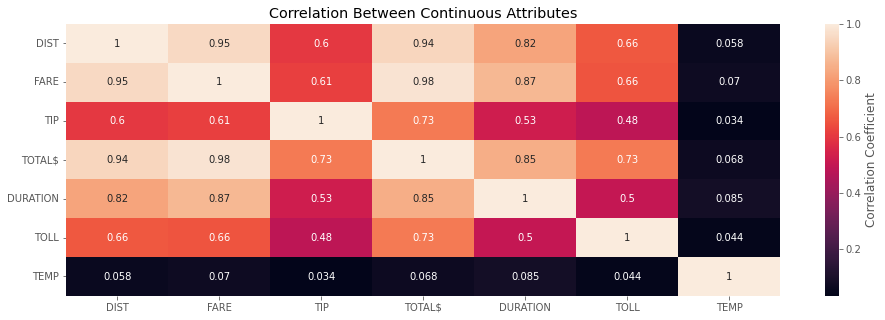

In [72]:
col = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'duration', 'tolls_amount', 'TAVG']
label = ['DIST', 'FARE', 'TIP', 'TOTAL$', 'DURATION', 'TOLL', 'TEMP']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = data[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

## Data Modelling

In [68]:
# Including only card payment, since tip on cash payment is not recorded

sample = data[data['payment_type'] == 1].sample(frac=0.05, replace=True, random_state=30034).reset_index(drop=True)

In [70]:
sample.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,time_desc,TMAX,TMIN,PSNOW,PSNOW_G,TAVG,Borough_x,Borough_y,DOborough,PUborough
0,2,2022-01-06 22:04:44,2022-01-06 22:21:04,small,6.76,1.0,144,140,1,21.0,...,Late Night,41,34,0,0,37.5,Manhattan,Manhattan,Manhattan,NaN
1,2,2022-02-10 00:03:24,2022-02-10 00:13:02,small,2.02,1.0,186,224,1,9.0,...,Late Night,54,37,0,0,45.5,Manhattan,Manhattan,Manhattan,NaN
2,2,2022-02-07 11:55:04,2022-02-07 12:14:51,high,2.11,1.0,236,162,1,13.5,...,Morning,37,30,T,0,33.5,Manhattan,Manhattan,Manhattan,NaN
3,1,2022-07-05 18:58:18,2022-07-05 19:04:24,small,0.80,1.0,238,239,1,6.0,...,Evening,87,70,0,0,78.5,Manhattan,Manhattan,Manhattan,NaN
4,2,2022-07-24 19:15:27,2022-07-24 19:27:00,small,4.39,1.0,137,87,1,14.5,...,Evening,95,79,0,0,87.0,Manhattan,Manhattan,Manhattan,NaN


### Linear Regression

In [73]:
COL = ['passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount', 
       'season', 'day_type', 'time_desc', 'PUborough', 'DOborough']
sample_filtered = sample.loc[:, COL].reset_index(drop=True)

In [75]:
# Splitting the data into train and test

# Here tip amount is our target varaible

y = sample_filtered['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)


In [86]:
print(np.isfinite(y_train).all())

True


In [76]:
# Scaling continuous variables

xCOLS = ['fare_amount', 'tolls_amount']

scaler = StandardScaler()
X_train[xCOLS] = scaler.fit_transform(X_train[xCOLS])
X_test[xCOLS] = scaler.transform(X_test[xCOLS])

In [77]:
# Regressing y by x

baseline = ols(formula='tip_amount ~ 1', data=X_train).fit()
print(baseline.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                nan
Time:                        19:33:31   Log-Likelihood:            -7.1236e+05
No. Observations:              296877   AIC:                         1.425e+06
Df Residuals:                  296876   BIC:                         1.425e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1801      0.005    649.941      0.0

In [78]:
base_train_pred = baseline.predict(X_train)
base_test_pred = baseline.predict(X_test)
train_rmse = mean_squared_error(y_train, base_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, base_test_pred, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 2.6659559184616586
Test RMSE: 2.671055911859504


In [79]:
# fit the model
full_model = ols(formula='tip_amount ~ C(passenger_count) + fare_amount + tolls_amount + season + time_desc + day_type + PUborough + DOborough', data=X_train).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     599.6
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:52:21   Log-Likelihood:                -54124.
No. Observations:               20471   AIC:                         1.083e+05
Df Residuals:                   20452   BIC:                         1.084e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [92]:
# predict and evaluate
full_train_pred = full_model.predict(X_train)
full_test_pred = full_model.predict(X_test)
# train_rmse = mean_squared_error(y_train, full_train_pred, squared=False)
# test_rmse = mean_squared_error(y_test, full_test_pred, squared=False)
# train_r2 = r2_score(y_train, full_train_pred)
# test_r2 = r2_score(y_test, full_test_pred)

# print("Full model")
# print("Train RMSE:", train_rmse)
# print("Test RMSE:", test_rmse)
# print("Train R2", train_r2)
# print("Test R2", test_r2)

In [93]:
full_train_pred

194212    8.275338
344768         NaN
17886          NaN
301474         NaN
331166    8.395071
            ...   
359783         NaN
358083         NaN
152315         NaN
117952         NaN
305711         NaN
Length: 296877, dtype: float64

### Gradient Boost Regression

In [94]:

# convert categorical data to dummy variable

sample_filtered = pd.get_dummies(sample_filtered, drop_first=True)

In [95]:
# train test split the sampled data

y = sample_filtered['tip_amount']
sample_filtered = sample_filtered.drop(['tip_amount'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)


In [96]:
# fit the model
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [97]:
reg.feature_importances_


array([9.65245508e-01, 2.62538759e-02, 0.00000000e+00, 3.42124714e-04,
       2.02052000e-04, 9.84102968e-05, 2.60053749e-04, 4.65423998e-04,
       8.10497057e-05, 9.16099107e-04, 1.29595672e-03, 8.08772471e-04,
       1.66478934e-03, 2.65443972e-04, 3.82885250e-04, 4.04473295e-04,
       8.79626023e-04, 4.33455440e-04])

In [98]:
# predict and evaluate

gbr_train_pred = reg.predict(X_train)
gbr_test_pred = reg.predict(X_test)
train_rmse = mean_squared_error(y_train, gbr_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, gbr_test_pred, squared=False)
train_r2 = r2_score(y_train, gbr_train_pred)
test_r2 = r2_score(y_test, gbr_test_pred)

print("Gradient Boost Regression")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Gradient Boost Regression
Train RMSE: 1.5580741695858005
Test RMSE: 1.5635268943076293
Train R2 0.6584373870445963
Test R2 0.6573547156600084


## Visualizations

In [113]:
yellow_data = pd.read_feather('/Users/shirishpandagare/Documents/DiptiFolder/GMU_Semesters/GMU_Summer_2023/NYC_taxi_analysis/raw_data/cleaned_data.feather')

In [114]:
# split data according to season

yellow_winter = yellow_data[yellow_data['season'] == 'winter'].reset_index(drop=True)
yellow_summer = yellow_data[yellow_data['season'] == 'summer'].reset_index(drop=True)